# Cavern storage capacity for variable heights

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib import ticker
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

from h2ss import capacity as cap
from h2ss import compare
from h2ss import data as rd
from h2ss import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

In [5]:
# exploration wells
_, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

# wind farms
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

# frequent shipping routes
_, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

# shipwrecks
_, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

# subsea cables
_, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

In [7]:
# distance from salt formation edge
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [6]:
zones, zds = fns.zones_of_interest(
    dat_xr=ds,
    constraints={"net_height": 85, "min_depth": 500, "max_depth": 2000},
)

## Generate caverns

In [8]:
caverns = fns.generate_caverns_hexagonal_grid(
    zones_df=zones, dat_extent=extent,
)

In [9]:
caverns = fns.cavern_dataframe(
    dat_zone=zds,
    cavern_df=caverns,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [10]:
# label caverns by depth and heights
caverns = fns.label_caverns(
    cavern_df=caverns,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [11]:
caverns, _ = fns.generate_caverns_with_constraints(
    cavern_df=caverns,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 979
------------------------------------------------------------
Excluding salt formation edges...
Number of potential caverns: 945
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 470
Caverns excluded: 50.26%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 399
Caverns excluded: 57.78%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 399
Caverns excluded: 57.78%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 399
Caverns excluded: 57.78%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 399
Caverns excluded: 57.78%
------------------------------------------------------------


## Capacity

### Cavern volume

In [12]:
caverns["cavern_total_volume"] = cap.cavern_volume(
    height=caverns["cavern_height"]
)
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_total_volume"]
)

### Mid-point temperature

In [13]:
caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

### Operating pressure

In [14]:
(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(
    thickness_overburden=caverns["TopDepthSeabed"],
    depth_water=-caverns["Bathymetry"],
)

### Hydrogen gas density

In [15]:
caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

### Working mass of hydrogen

In [16]:
(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

### Energy storage capacity in GWh

In [17]:
caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

## Stats

In [18]:
# proportion of working gas to total gas
caverns["working_mass_pct"] = caverns["working_mass"] / (
    caverns["working_mass"] + caverns["mass_operating_min"]
)

In [21]:
caverns.drop(
    columns=[
        "x",
        "y",
        "BaseDepth",
        "TopDepth",
        "TopTWT",
        "BaseDepthSeabed",
    ]
).describe()

,Thickness,TopDepthSeabed,Bathymetry,NetToGross,ThicknessNet,cavern_height,cavern_depth,cavern_total_volume,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,mass_operating_min,mass_operating_max,capacity,working_mass_pct
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,3.990000e+02,3.990000e+02,399.000000,3.990000e+02,3.990000e+02,399.000000,399.000000,3.990000e+02,3.990000e+02,3.990000e+02,399.000000,399.000000
mean,392.692637,1053.269888,-47.942230,0.621016,247.034600,157.034600,1133.269888,7.740566e+05,5.418396e+05,328.592020,7.908089e+06,2.108824e+07,5.498830,13.608384,4.456309e+06,3.023679e+06,7.479988e+06,148.494130,0.598067
std,69.115380,379.820048,13.520585,0.049226,66.379385,66.379385,379.820048,3.766699e+05,2.636690e+05,14.422505,2.682581e+06,7.153550e+06,1.563782,3.609161,2.489525e+06,1.726531e+06,4.214649e+06,82.956499,0.008105
min,316.764900,421.304826,-76.084564,0.554740,175.722230,85.722230,501.304826,3.693945e+05,2.585761e+05,303.868474,3.425755e+06,9.135347e+06,2.677520,6.909428,1.140792e+06,7.235337e+05,1.864326e+06,38.013734,0.581439
25%,347.146400,735.556125,-60.474541,0.582848,202.333742,112.333742,815.556125,5.204015e+05,3.642811e+05,316.378264,5.644452e+06,1.505187e+07,4.197347,10.622196,2.655239e+06,1.752281e+06,4.414269e+06,88.478450,0.592120
50%,375.021400,1030.925564,-43.752434,0.608638,228.252174,138.252174,1110.925564,6.674757e+05,4.672330e+05,327.711861,7.779068e+06,2.074418e+07,5.488176,13.658723,3.772847e+06,2.529201e+06,6.279934e+06,125.719653,0.598193
75%,417.471050,1318.617475,-41.456015,0.647911,270.484140,180.484140,1398.617475,9.071211e+05,6.349848e+05,338.976775,9.783203e+06,2.608854e+07,6.647271,16.296813,5.840389e+06,4.028253e+06,9.896179e+06,194.614750,0.604855
max,822.710300,1900.680682,-18.320551,0.750000,617.032725,527.032725,1980.680682,2.873612e+06,2.011528e+06,359.842039,1.382934e+07,3.687824e+07,8.687759,20.756258,1.655276e+07,1.113503e+07,2.768779e+07,551.574599,0.612483


In [22]:
# totals
caverns[
    [
        "cavern_volume",
        "working_mass",
        "capacity",
        "mass_operating_min",
        "mass_operating_max",
    ]
].sum()

cavern_volume         2.161940e+08
working_mass          1.778067e+09
capacity              5.924916e+04
mass_operating_min    1.206448e+09
mass_operating_max    2.984515e+09
dtype: float64

In [23]:
# compare to Ireland's electricity demand in 2050 (Deane, 2021)
compare.electricity_demand_ie(caverns_df=caverns)

Energy capacity as a percentage of Ireland's electricity demand in 2050: 48.56–70.53%


In [27]:
# total capacity at various depth/height combinations
s = caverns.groupby(["depth", "halite"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

,,capacity,%
depth,halite,,
"1,000 - 1,500",Rossall,30221.410919,51.007326
"500 - 1,000",Rossall,9007.915762,15.203449
"1,500 - 2,000",Rossall,9870.519163,16.659341
"1,000 - 1,500",Preesall,231.596637,0.390886
"500 - 1,000",Preesall,3261.128418,5.504092
"1,500 - 2,000",Preesall,1893.482327,3.195796
"1,000 - 1,500",Fylde,1643.233443,2.773429
"1,500 - 2,000",Fylde,870.976103,1.470023
"500 - 1,000",Fylde,2248.894946,3.795657


In [28]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",32096.240999
"1,500 - 2,000",12634.977593
"500 - 1,000",14517.939126


In [29]:
s.groupby("halite").sum()[["capacity"]]

,capacity
halite,
Fylde,4763.104492
Preesall,5386.207382
Rossall,49099.845844


In [30]:
# number of caverns
s = caverns.groupby(["depth", "halite"], sort=False)[["capacity"]].count()
s["%"] = s["capacity"] / len(caverns) * 100
s

,,capacity,%
depth,halite,,
"1,000 - 1,500",Rossall,172,43.107769
"500 - 1,000",Rossall,82,20.551378
"1,500 - 2,000",Rossall,46,11.528822
"1,000 - 1,500",Preesall,2,0.501253
"500 - 1,000",Preesall,37,9.273183
"1,500 - 2,000",Preesall,14,3.508772
"1,000 - 1,500",Fylde,13,3.258145
"1,500 - 2,000",Fylde,5,1.253133
"500 - 1,000",Fylde,28,7.017544


In [31]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",187
"1,500 - 2,000",65
"500 - 1,000",147


In [32]:
s.groupby("halite").sum()[["capacity"]]

,capacity
halite,
Fylde,46
Preesall,53
Rossall,300


## Map

In [34]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [67]:
def plot_map_alt(
    dat_xr,
    cavern_df,
    zones_gdf,
    classes,
    quantity="capacity", quantity_label="Hydrogen storage \ncapacity [GWh]", top_depth=True,
    fontsize=11.5,
):
    """Helper function to plot caverns within the zones of interest"""
    plt.figure(figsize=(20, 11.5))
    axis1 = plt.axes(projection=ccrs.epsg(rd.CRS))
    legend_handles1 = []
    classes = sorted(classes)

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis1,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis1, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis1,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Area of interest",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis1,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    legend_handles1.append(mpatches.Patch(label=quantity_label, visible=False))

    colours = [int(n * 255 / (len(classes) - 1)) for n in range(len(classes))]
    for n, y in enumerate(colours):
        if n == 0:
            c = cavern_df[cavern_df[quantity] < classes[1]]
            label1 = f"< {classes[1]}"
        elif n == len(classes) - 1:
            c = cavern_df[cavern_df[quantity] >= classes[n]]
            label1 = f"≥ {classes[n]}"
        else:
            c = cavern_df[
                (cavern_df[quantity] >= classes[n])
                & (cavern_df[quantity] < classes[n + 1])
            ]
            label1 = f"{classes[n]}–{classes[n + 1]}"
        if top_depth:
            for df, markersize in zip(
                [
                    c[c["depth"] == "500 - 1,000"],
                    c[c["depth"] == "1,000 - 1,500"],
                    c[c["depth"] == "1,500 - 2,000"],
                ],
                [30, 60, 30],
            ):
                if len(df) > 0:
                    df.centroid.plot(
                        ax=axis1,
                        zorder=3,
                        linewidth=0,
                        marker=".",
                        markersize=markersize,
                        color=sns.color_palette("flare", 256)[y],
                    )
        else:
            gpd.GeoDataFrame(cavern_df, geometry=cavern_df.centroid).plot(
                ax=axis1,
                scheme="UserDefined",
                classification_kwds={"bins": classes[1:]},
                column=quantity,
                zorder=3,
                marker=".",
                cmap="flare",
                markersize=40,
            )
        legend_handles1.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[y], label=label1
            )
        )

    if top_depth:
        legend_handles1.append(
            mpatches.Patch(label="Cavern top depth [m]", visible=False)
        )
        for markersize, label1 in zip(
            [6, 3], ["1,000–1,500", "500–1,000 or \n1,500–2,000"]
        ):
            legend_handles1.append(
                Line2D(
                    [0],
                    [0],
                    marker=".",
                    linewidth=0,
                    label=label1,
                    color="darkslategrey",
                    markersize=markersize,
                )
            )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    basemap = cx.providers.CartoDB.VoyagerNoLabels
    cx.add_basemap(
        axis1, crs=rd.CRS, source=basemap, zoom=12, attribution=False
    )
    axis1.text(
        shape.bounds["minx"][0] - 800,
        shape.bounds["miny"][0] - 800,
        basemap["attribution"],
        fontsize=10,
    )

    axis1.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
        xlabel_style={"fontsize": fontsize},
        ylabel_style={"fontsize": fontsize, "rotation": 90},
        xformatter=LongitudeFormatter(auto_hide=False, dms=True),
        yformatter=LatitudeFormatter(auto_hide=False, dms=True),
    )
    axis1.add_artist(
        ScaleBar(
            1,
            box_alpha=0,
            location="lower right",
            color="darkslategrey",
            width_fraction=0.0075,
            font_properties={"size": fontsize},
        )
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles1,
        fontsize=fontsize,
    )

    plt.tight_layout()
    plt.savefig(
        os.path.join("graphics", f"fig_caverns_capacity_ntg_height.jpg"),
        format="jpg",
        dpi=600,
    )
    plt.show()

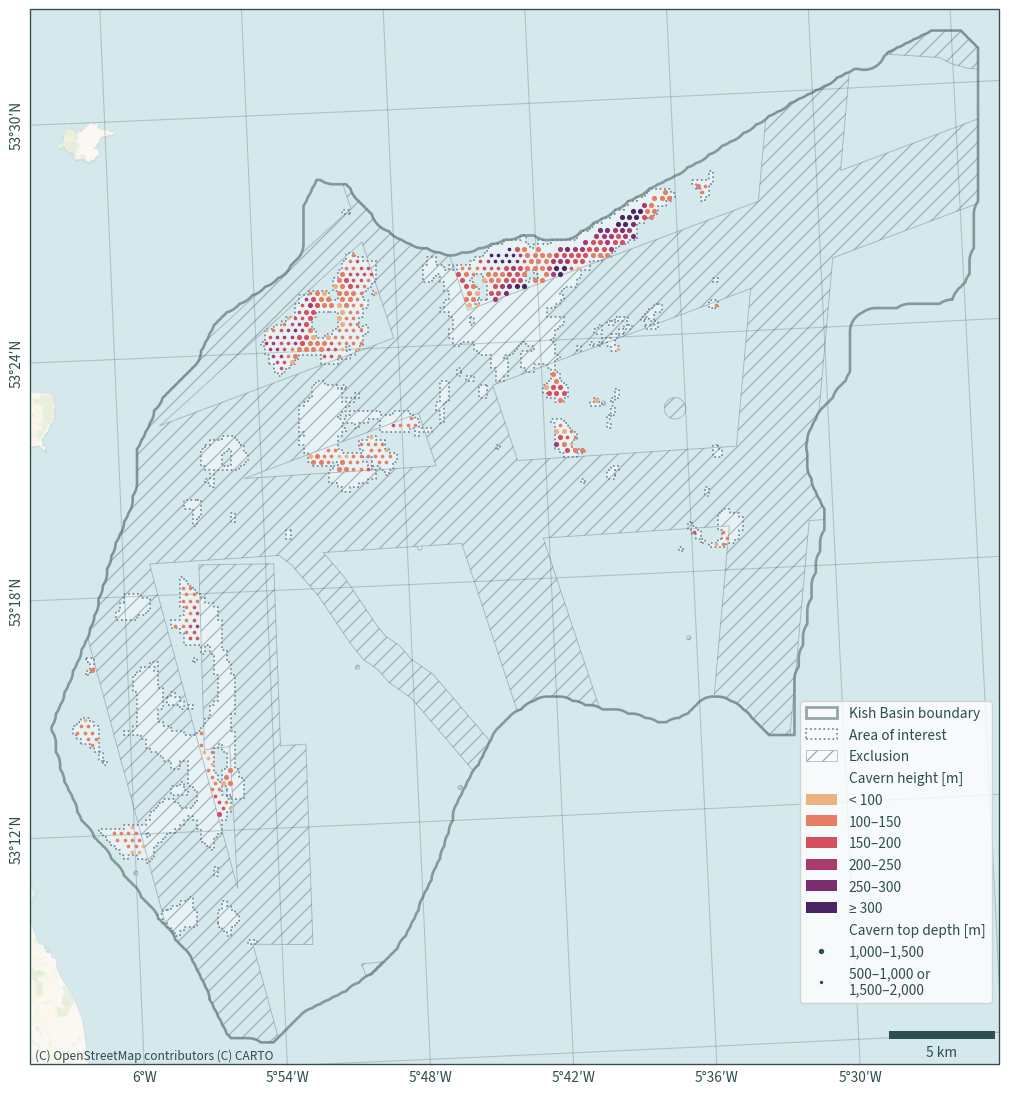

In [68]:
plot_map_alt(ds, caverns, zones, [0, 100, 150, 200, 250, 300], "cavern_height", "Cavern height [m]")

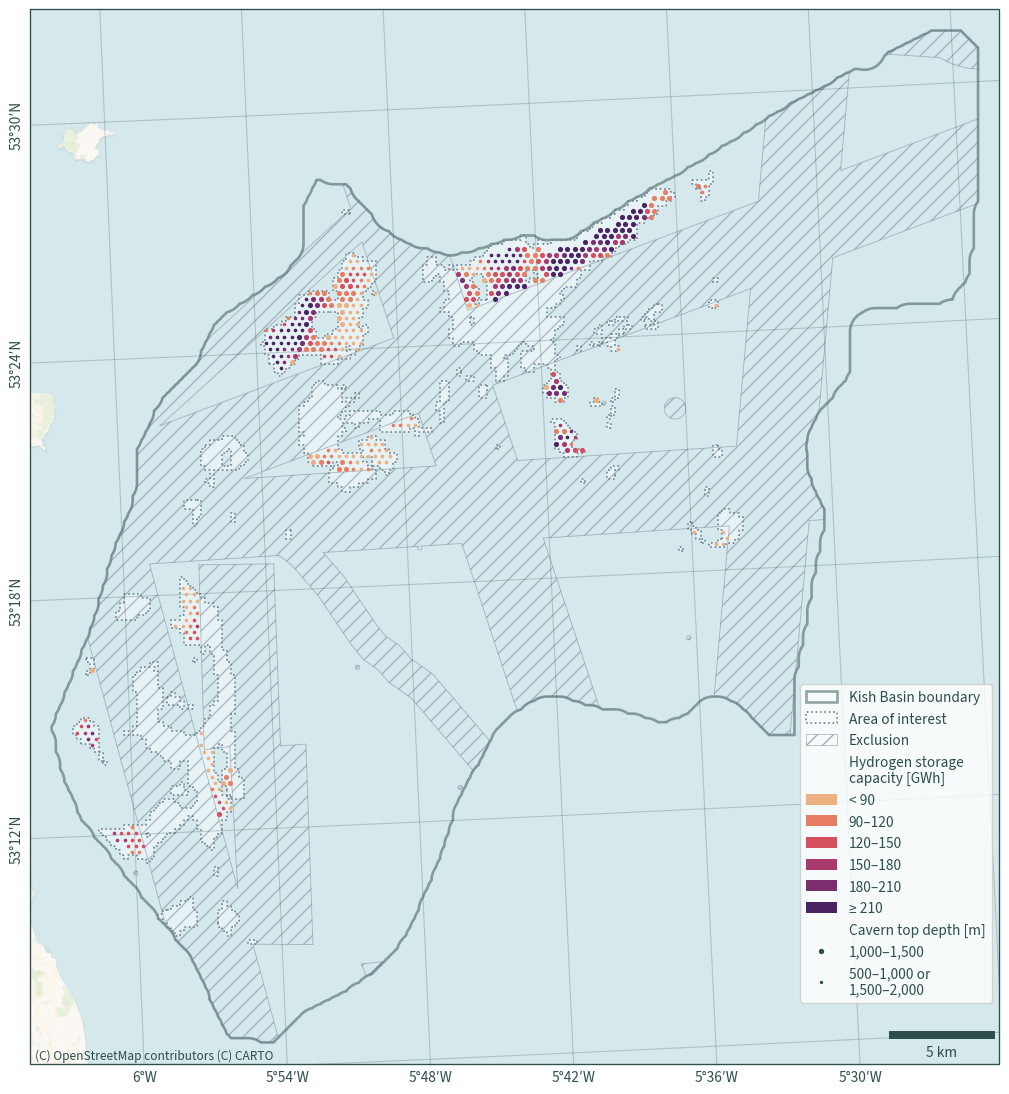

In [69]:
plot_map_alt(ds, caverns, zones, [0, 90, 120, 150, 180, 210])